# Set Up Notebook

In [1]:
###########
# IMPORTS #
###########

# System and file handling
import os
from pathlib import Path

# Data processing and math
import pandas as pd
import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook display
from IPython.display import display, HTML


#################
# CONFIGURATION #
#################

# Set path to corpus directory
base_path = r'/Users/amb/Desktop/Corpus'

# Configure global display settings for pandas
pd.options.display.float_format = '{:,.4f}'.format


#########################
# CONSPIRACY CATEGORIES #
#########################
conspiracy_categories = {
    "Governments and Elites": [
       "agency",
        "authorit*",
        "black ops",
        "bureau*",
        "cabal*",
        "clandestine",
        "corrupt*",
        "deep state",
        "elite*",
        "enlighten*",
        "establishment",
        "globalist*",
        "government*",
        "illuminati*",
        "initiate*",
        "intelligence",
        "jew*",
        "mason*",
        "new world order",
        "police state",
        "secret society",
        "surveil*"
    ],
    
    "Technology and Biology": [
        "bio-weapon*",
        "chemical*",
        "chemtrail*",
        "chip*",
        "clon*",
        "dna",
        "fluoride",
        "frequency",
        "genetic*",
        "implant*",
        "mk-ultra",
        "nanobot*",
        "pandem*",
        "pathogen*",
        "poison*",
        "radiation",
        "satellite*",
        "toxic*",
        "vaccin*",
        "virus"
    ],
    
    "Information and Disinformation": [
        "brainwash*",
        "classified",
        "cover-up",
        "decept*",
        "distort*",
        "fake*",
        "hoax*",
        "indoctrinate*",
        "manipulate*",
        "masses",
        "media",
        "paranoi*",
        "red pil",
        "propaganda",
        "scripted",
        "sheep*",
        "spie*",
        "staged",
        "subliminal*",
        "top-secret",
        "truth",
        "unveil*",
        "wiretap*"
    ],
    
    "Extraterrestrial and Paranormal": [
        "abduct*",
        "alien*",
        "ancient",
        "anomal*",
        "apocalyp*",
        "armageddon",
        "artifact*",
        "asteroid*",
        "beaming",
        "beast*",
        "cosmic",
        "creature*",
        "extraterrestrial*",
        "interstellar",
        "lifeform*",
        "meteor*",
        "otherworldly",
        "paranormal",
        "prophecy",
        "ritual*",
        "sacred",
        "saucer*",
        "scripture*",
        "spacecraft*",
        "telepathy",
        "ufo*",
        "unidentified"
    ]
}


#########
# GAMES #
#########

# Define order
ordered_games = [
    "Grand Theft Auto (1997)",
    "Grand Theft Auto: London, 1969 (1999)",
    "Grand Theft Auto: London, 1961 (1999)",
    "Grand Theft Auto 2 (1999)",
    "Grand Theft Auto III (2001)",
    "Grand Theft Auto: Vice City (2002)",
    "Grand Theft Auto: San Andreas (2004)",
    "Grand Theft Auto Advance (2004)",
    "Grand Theft Auto: Liberty City Stories (2005)",
    "Grand Theft Auto: Vice City Stories (2006)",
    "Grand Theft Auto IV (2008)",
    "Grand Theft Auto IV: The Lost and Damned (2009)",
    "Grand Theft Auto IV: The Ballad of Gay Tony (2009)",
    "Grand Theft Auto: Chinatown Wars (2009)",
    "Grand Theft Auto V (2013)"
]

# Map abbreviations to games
short_names_map = {
    "Grand Theft Auto (1997)": "GTA (1997)",
    "Grand Theft Auto: London, 1969 (1999)": "GTA London, 1969 (1999)",
    "Grand Theft Auto: London, 1961 (1999)": "GTA London, 1961 (1999)",
    "Grand Theft Auto 2 (1999)": "GTA 2 (1999)",
    "Grand Theft Auto III (2001)": "GTA III (2001)",
    "Grand Theft Auto: Vice City (2002)": "GTA: VC (2002)",
    "Grand Theft Auto: San Andreas (2004)": "GTA: SA (2004)",
    "Grand Theft Auto Advance (2004)": "GTA Advance (2004)",
    "Grand Theft Auto: Liberty City Stories (2005)": "GTA: LCS (2005)",
    "Grand Theft Auto: Vice City Stories (2006)": "GTA: VCS (2006)",
    "Grand Theft Auto IV (2008)": "GTA IV (2008)",
    "Grand Theft Auto IV: The Lost and Damned (2009)": "GTA: TLAD (2009)",
    "Grand Theft Auto IV: The Ballad of Gay Tony (2009)": "GTA: TBoGT (2009)",
    "Grand Theft Auto: Chinatown Wars (2009)": "GTA: CTW (2009)",
    "Grand Theft Auto V (2013)": "GTA V (2013)"
}

# Map titles to folder names
folder_mapping = {
    "gta": "Grand Theft Auto (1997)",
    "gta 2": "Grand Theft Auto 2 (1999)",
    "gta iii": "Grand Theft Auto III (2001)",
    "gta vc": "Grand Theft Auto: Vice City (2002)",
    "gta sa": "Grand Theft Auto: San Andreas (2004)",
    "gta advance": "Grand Theft Auto Advance (2004)",
    "gta lcs": "Grand Theft Auto: Liberty City Stories (2005)",
    "gta vcs": "Grand Theft Auto: Vice City Stories (2006)",
    "gta iv": "Grand Theft Auto IV (2008)",
    "gta ctw": "Grand Theft Auto: Chinatown Wars (2009)",
    "gta v": "Grand Theft Auto V (2013)"
}

def get_game_label(path_string):
    """
    Identifies game title from file path.
    Handles DLC separation for GTA IV.
    Maps titles to folder names.
    """
    
    # Normalize paths
    p = str(path_string).lower().replace('\\', '/')
    
    # Check for DLCs
    if '1969' in p:
        return "Grand Theft Auto: London, 1969 (1999)"
    if '1961' in p:
        return "Grand Theft Auto: London, 1961 (1999)"
    if 'tlad' in p:
        return "Grand Theft Auto IV: The Lost and Damned (2009)"
    if 'tbogt' in p:
        return "Grand Theft Auto IV: The Ballad of Gay Tony (2009)"
    
    # Extract folder names
    parts = p.split('/')
    
    for part in parts:
        if part in folder_mapping:
            return folder_mapping[part]
    
    return "Unknown"


############
# CLEANING #
############
def is_technical_string(text):
    """
    Filters technical artifacts.
    """
    if '_' in text: return True
    
    if re.fullmatch(r'[\d\W_]+', text): return True
    
    if len(text) > 1 and text.isupper():
        if ' ' in text:
            return False
        return True
    
    return False

def extract_game_text(line, ext):
    """
    Extracts and cleans text based on file extension.
    """
    line = line.strip()

    # Skip header
    if not line or line in ['{', '}', 'Version'] or line.startswith(('CharSize', 'NeedDecode', 'SingleFileTable')):
        return None
    
    text = None
    if ext == '.oxt':
        if '=' in line: text = line.split('=', 1)[1].strip()
    elif ext == '.txt':
        if line.startswith('[') and line.endswith(']'): return None
        if '//' in line: text = line.split('//', 1)[1].strip()
        else: text = line
    elif ext == '.csv':
        parts = re.findall(r'"(.*?)"', line)
        if len(parts) >= 2:
            if parts[0].lower() in ['gxt', 'id', 'key']: return None
            text = parts[1]
            
    if text:
        
        # Remove markup
        text = re.sub(r'~.*?~|#|<<|>>', '', text).strip()
        
        # Remove technical strings
        if text and not is_technical_string(text):
            return text if len(text) > 1 else None
    return None


#############
# WILDCARDS #
#############
def wildcard_to_regex(wildcard_pattern):
    """
    Converts search patterns into searchable regex objects.
    """
    regex_str = r'\b' + re.escape(wildcard_pattern).replace(r'\*', r'\w*') + r'\b'
    return re.compile(regex_str, re.IGNORECASE)

# Decipher Files for London 1969 and London 1961

In [2]:
def decipher(input_path, output_path):
    """
    Deciphers FXT files using a -1 ASCII shift.
    Restructures text by forcing newlines before every opening bracket.
    """
    input_file = Path(input_path)
    output_file = Path(output_path)
    
    # Check existence of file
    if not input_file.exists():
        print("File not found.")
        return
    
    try:
        # Load data
        with open(input_file, 'rb') as f:
            raw_bytes = f.read()
        
        # Apply shift
        deciphered_chars = []
        
        for b in raw_bytes:
            shifted_byte = (b - 1) % 256
            char = chr(shifted_byte)
            
            # Structure text
            if char == '[':
                deciphered_chars.append('\n')
           
            # Clean text
            if 32 <= shifted_byte <= 126 or shifted_byte in [10, 13]:
                deciphered_chars.append(char)
            elif shifted_byte == 91:
                deciphered_chars.append('[')
        
        final_text = "".join(deciphered_chars)
        
        # Export file
        with open(output_file, 'w', encoding = 'utf-8') as f:
            f.write(final_text)
        
        print(f"File saved to '{output_file}'.")
    
    except Exception as e:
        print(f"Error: {e}")

# Execute
# enguk.fxt  -> gta_london_1969.txt
# enguke.fxt -> gta_london_1961.txt
in_p = "/Users/amb/Desktop/Corpus/speuk.FXT" 
out_p = "/Users/amb/Desktop/Corpus/speuk.txt"

# decipher(in_p, out_p)

# Describe Raw and Cleaned Corpus

In [3]:
def run_comparative_audit(root_dir):
    """
    Performs an audit to quantify noise reduction.
    Measures lines, characters, tokens, and lexical diversity.
    """
    
    # Initialize metric containers
    raw_stats = {'lines': 0, 'chars': 0, 'tokens': []}
    clean_stats = {'lines': 0, 'chars': 0, 'tokens': []}
    total_files = 0
    
    root_path = Path(root_dir)
    valid_extensions = {'.oxt', '.txt', '.csv'}
    
    # Collect data
    for file_path in root_path.rglob('*'):
        ext = file_path.suffix.lower()
        if ext in valid_extensions:
            total_files += 1
            try:
                with open(file_path, 'r', encoding = 'utf-8', errors = 'ignore') as f:
                    for line in f:
                        raw_line = line.strip()
                        if not raw_line: continue
                        
                        # Process raw data
                        raw_stats['lines'] += 1
                        raw_stats['chars'] += len(raw_line)
                        raw_stats['tokens'].extend(re.findall(r'\b\w+\b', raw_line.lower()))
                        
                        # Process cleaned data
                        clean_text = extract_game_text(line, ext)
                        if clean_text:
                            clean_stats['lines'] += 1
                            clean_stats['chars'] += len(clean_text)
                            clean_stats['tokens'].extend(re.findall(r'\b[a-zA-Z-]{2,}\b', clean_text.lower()))
            except Exception:
                pass
    
    # Calculate metrics
    def calculate_metrics(s):
        """
        Helps to calculate N (tokens), V (types), and TTR.
        """
        n = len(s['tokens'])
        v = len(set(s['tokens']))
        ttr = v / n if n > 0 else 0
        return [s['lines'], s['chars'], n, v, ttr]
    
    raw_vals = calculate_metrics(raw_stats)
    clean_vals = calculate_metrics(clean_stats)
    
    # Calculate difference
    diff_vals = [r - c for r, c in zip(raw_vals, clean_vals)]
    
    # Construct DataFrame
    df_comp = pd.DataFrame({
        'Metric': [
            'Lines', 
            'Characters', 
            'Tokens', 
            'Unique Word Types', 
            'Type-Token Ratio'
        ],
        'Raw': raw_vals,
        'Cleaned': clean_vals,
        'Difference': diff_vals
    })
    
    print(f"Audit complete. {total_files} files analyzed.")
    return df_comp

# Execute and display
audit_results = run_comparative_audit(base_path)

display(audit_results)

Audit complete. 952 files analyzed.


,Metric,Raw,Cleaned,Difference
0,Lines,"632,517.0000","379,194.0000","253,323.0000"
1,Characters,"27,961,234.0000","15,714,071.0000","12,247,163.0000"
2,Tokens,"4,146,908.0000","2,747,884.0000","1,399,024.0000"
3,Unique Word Types,"769,987.0000","47,105.0000","722,882.0000"
4,Type-Token Ratio,0.1857,0.0171,0.1685


# Build Master Corpus

In [4]:
def build_master_corpus(root_dir):
    """
    Aggregates cleaned text from all files into a single DataFrame.
    """
    all_data = []
    root_path = Path(root_dir)
    extensions = {'.oxt', '.txt', '.csv'}
        
    # Collect data
    for file_path in root_path.rglob('*'):
        ext = file_path.suffix.lower()
        if ext in extensions:
            
            # Create clean relative paths
            rel_path = str(file_path.relative_to(root_path)).replace('\\', '/')
            
            # Map game titles to paths
            game_title = get_game_label(rel_path)
            
            try:
                with open(file_path, 'r', encoding = 'utf-8', errors = 'ignore') as f:
                    for line in f:
                        
                        # Apply cleaning
                        text = extract_game_text(line, ext)
                        
                        if text:
                            all_data.append({
                                'Game': game_title,
                                'Path': rel_path,
                                'Text': text
                            })
            except Exception:
                pass
    
    return pd.DataFrame(all_data)

# Construct DataFrame
df_master = build_master_corpus(base_path)

# Export file
if not df_master.empty:
    output_file = "conspiracy_gta_master_corpus.csv"
    df_master.to_csv(output_file, index = False, encoding = 'utf-8-sig')
    
    print(f"Corpus saved to '{output_file}'.")
    
    # Display preview
    display(df_master.head(25))
else:
    print("No data found.")

Corpus saved to 'conspiracy_gta_master_corpus.csv'.


,Game,Path,Text
0,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Splitz-6 ATV
1,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Accuracy
2,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Admiral
3,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Air Ambulance
4,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,'Crims On Water Wings'
5,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,'Crims On Wings'
6,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Ambassador
7,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Ambulance
8,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Your Body Armor is in good condition.
9,Grand Theft Auto: Vice City Stories (2006),GTA VCS/gta_vcs.txt,Cost: $


# Search for Keywords

In [5]:
# Configure search
search_patterns = ["fuck"]
export_results_file = "conspiracy_gta_search_results.csv"

# Define search
def perform_search(df, patterns):
    """
    Scans the DataFrame for keywords and returns hits.
    """
    hits = []
    regex_list = [(p, wildcard_to_regex(p)) for p in patterns]
        
    for _, row in df.iterrows():
        text = str(row['Text'])
        for original_pattern, regex in regex_list:
            match = regex.search(text)
            if match:
                hits.append({
                    'Game': row['Game'],
                    'Pattern': original_pattern,
                    'Match': match.group(0),
                    'Context': text,
                    'Path': row['Path']
                })
                
                # Break after first match in line to avoid redundancy
                break
    
    return pd.DataFrame(hits)

# Execute
if 'df_master' in locals() and not df_master.empty:
    df_hits = perform_search(df_master, search_patterns)
    
    if not df_hits.empty:
        
        # Export results
        df_hits.to_csv(export_results_file, index = False, encoding = 'utf-8-sig')
        
        print(f"{len(df_hits):,} matches found.")
        print(f"Results exported to '{export_results_file}'.")
        
        # Display preview
        display(df_hits.head(25))
    else:
        print("No matches found.")
else:
    print("No data found.")

3,899 matches found.
Results exported to 'conspiracy_gta_search_results.csv'.


,Game,Pattern,Match,Context,Path
0,Grand Theft Auto: Vice City Stories (2006),fuck,fuck,Mendez: Our 'product' is still going missing. ...,GTA VCS/gta_vcs.txt
1,Grand Theft Auto: Vice City Stories (2006),fuck,Fuck,Fuck.,GTA VCS/gta_vcs.txt
2,Grand Theft Auto: Vice City Stories (2006),fuck,fuck,What the fuck is this?,GTA VCS/gta_vcs.txt
3,Grand Theft Auto: Vice City Stories (2006),fuck,fuck,"Chill the fuck out, my friend. You're really g...",GTA VCS/gta_vcs.txt
4,Grand Theft Auto: Vice City Stories (2006),fuck,Fuck,"Fuck you, Martinez.",GTA VCS/gta_vcs.txt
5,Grand Theft Auto: Vice City Stories (2006),fuck,fuck,You want me to fuck you up?,GTA VCS/gta_vcs.txt
6,Grand Theft Auto: Vice City Stories (2006),fuck,Fuck,Fuck you.,GTA VCS/gta_vcs.txt
7,Grand Theft Auto: Vice City Stories (2006),fuck,fuck,"Ay, change the record baby... fuck you, fuck y...",GTA VCS/gta_vcs.txt
8,Grand Theft Auto: Vice City Stories (2006),fuck,fuck,For fuck's sake Phil! Do something!,GTA VCS/gta_vcs.txt
9,Grand Theft Auto: Vice City Stories (2006),fuck,Fuck,Fuck this place up.,GTA VCS/gta_vcs.txt


# Calculate Further Metrics

In [6]:
def calculate_advanced_metrics(df):
    """
    Calculates linguistic density metrics.
    """
    
    # Collect all words
    word_pattern = re.compile(r'\b[a-zA-Z-]{2,}\b')
    
    # Create counters
    word_counts = Counter()
    line_word_counts = []
    total_chars_in_words = 0
    total_tokens = 0
        
    # Count
    for text in df['Text']:
        found_words = word_pattern.findall(str(text).lower())
        
        word_counts.update(found_words)
        total_tokens += len(found_words)
        line_word_counts.append(len(found_words))
        
        for w in found_words:
            total_chars_in_words += len(w)
    
    # Calculate hapax legomena
    hapax_list = [word for word, count in word_counts.items() if count == 1]
    n_hapax = len(hapax_list)
    vocabulary_size = len(word_counts)
    
    percentage_hapax = (n_hapax / vocabulary_size) * 100 if vocabulary_size > 0 else 0
    
    # Calculate average line length
    avg_line_length = sum(line_word_counts) / len(line_word_counts) if line_word_counts else 0
    
    # Calculate average word length
    avg_word_chars = total_chars_in_words / total_tokens if total_tokens > 0 else 0
    
    # Build result table
    metrics = [
        ("Total Tokens", total_tokens),
        ("Unique Types", vocabulary_size),
        ("Hapax Legomena", n_hapax),
        ("Percentage of Hapax Legomena", f"{percentage_hapax:.2f} %"),
        ("Average Line Length (Words)", f"{avg_line_length:.2f}"),
        ("Average Word Length (Characters)", f"{avg_word_chars:.2f}")
    ]
    
    return pd.DataFrame(metrics, columns = ['Metric', 'Value'])

# Execute
if 'df_master' in locals():
    df_adv_metrics = calculate_advanced_metrics(df_master)
    display(df_adv_metrics)
else:
    print("No data found.")

,Metric,Value
0,Total Tokens,2747884
1,Unique Types,47105
2,Hapax Legomena,16732
3,Percentage of Hapax Legomena,35.52 %
4,Average Line Length (Words),7.25
5,Average Word Length (Characters),4.45


# Calculate Lexical Density, Display Top Bigrams, and Generate Word Length Distribution Graph

Lexical density: 0.7771 (Ratio of content words to total words)
Top bigrams:
- "to the": 9310 times
- "in the": 8095 times
- "you re": 7298 times
- "of the": 6494 times
- "on the": 5926 times
- "press to": 5854 times
- "you can": 5081 times
- "this is": 4038 times
- "if you": 3753 times
- "to be": 3494 times
- "you know": 3467 times
- "we re": 3356 times
- "for the": 3113 times
- "are you": 3044 times
- "at the": 3026 times
- "out of": 2975 times
- "to get": 2730 times
- "you have": 2716 times
- "you are": 2578 times
- "going to": 2564 times
- "come on": 2521 times
- "want to": 2446 times
- "you want": 2402 times
- "will be": 2254 times
- "need to": 2244 times
Graph saved as 'conspiracy_gta_word_length_distribution.png'.


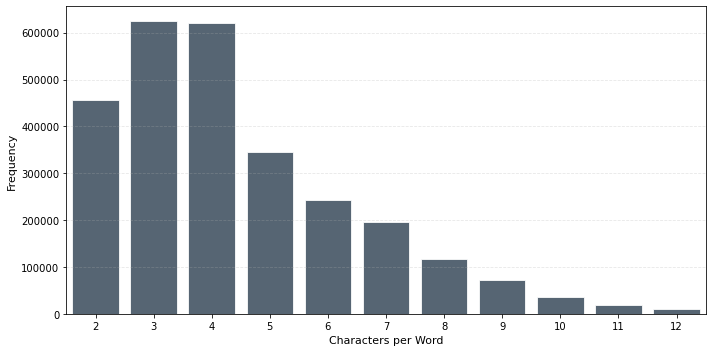

In [7]:
def run_lexical_fingerprint(df):
    """
    Analyzes bigrams, word length distribution, and lexical density.
    """
    all_tokens = []
    bigram_counts = Counter()
    
    # Pre-compile regex
    word_pattern = re.compile(r'\b[a-zA-Z-]{2,}\b')
    
    for text in df['Text']:
        # Clean and tokenize line by line
        line_tokens = word_pattern.findall(str(text).lower())
        all_tokens.extend(line_tokens)
        
        # Calculate bigrams
        if len(line_tokens) >= 2:
            line_bigrams = zip(line_tokens, line_tokens[1:])
            bigram_counts.update([f"{a} {b}" for a, b in line_bigrams])
    
    # Collect top 25 bigrams
    top_bigrams = bigram_counts.most_common(25)
    
    # Calculate word lengths
    word_lengths = [len(w) for w in all_tokens]
    len_dist = Counter(word_lengths)
    
    # Calculate lexical density
    stopwords = {"the", "a", "an", "and", "or", "but", "if", "then", "at", "by", 
                 "for", "with", "to", "of", "in", "on", "is", "was", "be", "it", "you", "that"}
    content_words_count = sum(1 for w in all_tokens if w not in stopwords)
    lex_density = content_words_count / len(all_tokens) if all_tokens else 0
    
    # Display results
    print(f"Lexical density: {lex_density:.4f} (Ratio of content words to total words)")
    print("Top bigrams:")
    for phrase, count in top_bigrams:
        print(f"- \"{phrase}\": {count} times")
    
    # Generate graph
    plt.figure(figsize = (10, 5))
    
    # Filter for word lengths (2 to 12 characters)
    plot_data = {length: len_dist[length] for length in range(2, 13)}
    
    plt.bar(plot_data.keys(), plot_data.values(), color = '#2c3e50', edgecolor = 'white', alpha = 0.8)
    
    plt.xlabel('Characters per Word', fontsize = 11)
    plt.ylabel('Frequency', fontsize = 11)
    
    plt.xticks(range(2, 13))
    plt.xlim(1.5, 12.5)
    
    plt.grid(axis = 'y', linestyle = '--', alpha = 0.3)
    plt.tight_layout()
    
    plt.savefig('conspiracy_gta_word_length_distribution.png', dpi = 300)
    
    print("Graph saved as 'conspiracy_gta_word_length_distribution.png'.")

# Execute
if 'df_master' in locals():
    run_lexical_fingerprint(df_master)

# Generate Heatmap

Graph saved as 'conspiracy_gta_heatmap.png'.


Category,Governments and Elites,Technology and Biology,Information and Disinformation,Extraterrestrial and Paranormal
Grand Theft Auto (1997),1.6854,1.6854,1.6854,5.6180
"Grand Theft Auto: London, 1969 (1999)",5.7471,4.5977,0.0000,0.0000
"Grand Theft Auto: London, 1961 (1999)",1.8868,1.8868,0.0000,0.0000
Grand Theft Auto 2 (1999),2.7635,5.9218,1.1844,5.5270
Grand Theft Auto III (2001),2.8421,0.4060,0.4060,0.0000
Grand Theft Auto: Vice City (2002),4.3850,1.5348,1.0963,0.2193
Grand Theft Auto: San Andreas (2004),1.4398,0.9390,3.2553,2.4415
Grand Theft Auto Advance (2004),6.1941,2.0647,5.5058,3.4412
Grand Theft Auto: Liberty City Stories (2005),1.4842,0.3711,1.6698,0.0000
Grand Theft Auto: Vice City Stories (2006),1.2510,0.4691,2.8147,0.0000


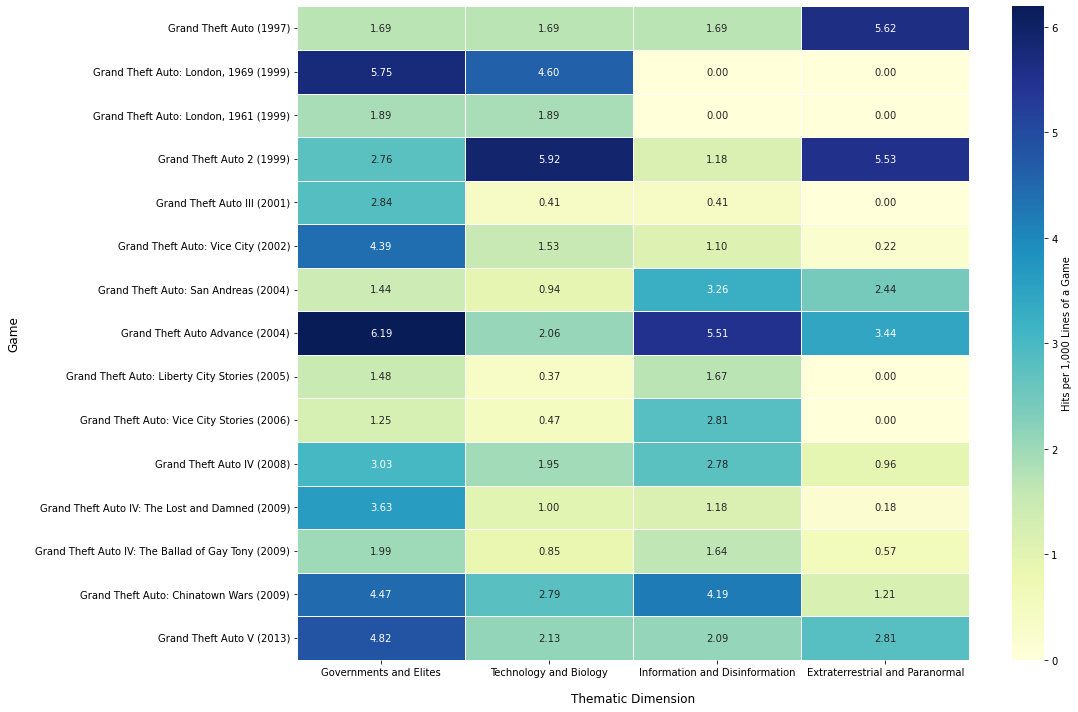

In [8]:
def run_heatmap(df):
    """
    Creates a normalized heatmap.
    """
    
    # Calculate totals
    game_totals = df['Game'].value_counts()
    
    # Get categories
    category_order = list(conspiracy_categories.keys())
    
    # Prepare regex objects
    compiled_cats = {cat: [wildcard_to_regex(p) for p in patterns] for cat, patterns in conspiracy_categories.items()}
    
    results = []
    
    for cat, regexes in compiled_cats.items():
        
        # Combine all patterns of a category into one regex
        combined_pattern = "|".join([r.pattern for r in regexes])
        combined_regex = re.compile(combined_pattern, re.IGNORECASE)
        
        # Search for hits
        mask = df['Text'].str.contains(combined_regex, na = False)
        hits = df.loc[mask, 'Game']
        
        for game in hits:
            results.append({'Game': game, 'Category': cat})
    
    df_hits = pd.DataFrame(results)
    
    # Fallback if nothing is found
    if df_hits.empty:
        print("No matches found for any category.")
        return
    
    # Create matrix
    matrix_abs = df_hits.groupby(['Game', 'Category']).size().unstack(fill_value = 0)
    
    # Normalize
    matrix_rel = matrix_abs.divide(game_totals, axis = 0) * 1000
    
    # Handle zero hits
    matrix_rel = matrix_rel.reindex(index = ordered_games, columns = category_order).fillna(0)
    
    # Generate graph
    plt.figure(figsize = (16, 10))
    
    sns.heatmap(matrix_rel, annot = True, fmt = '.2f', cmap = 'YlGnBu',
                cbar_kws={'label': 'Hits per 1,000 Lines of a Game'}, linewidths = .5)
    
    plt.xlabel('Thematic Dimension', fontsize = 12, labelpad = 15)
    plt.ylabel('Game', fontsize = 12, labelpad = 15)
    
    plt.tight_layout()
    plt.savefig('conspiracy_gta_heatmap.png', dpi = 300)
    
    print("Graph saved as 'conspiracy_gta_heatmap.png'.")
    display(matrix_rel)

# Execute
if 'df_master' in locals() and not df_master.empty:
    run_heatmap(df_master)

# Generate Barcode for Thematic Dimensions

Graph saved as 'conspiracy_gta_barcode_dimensions.png'.


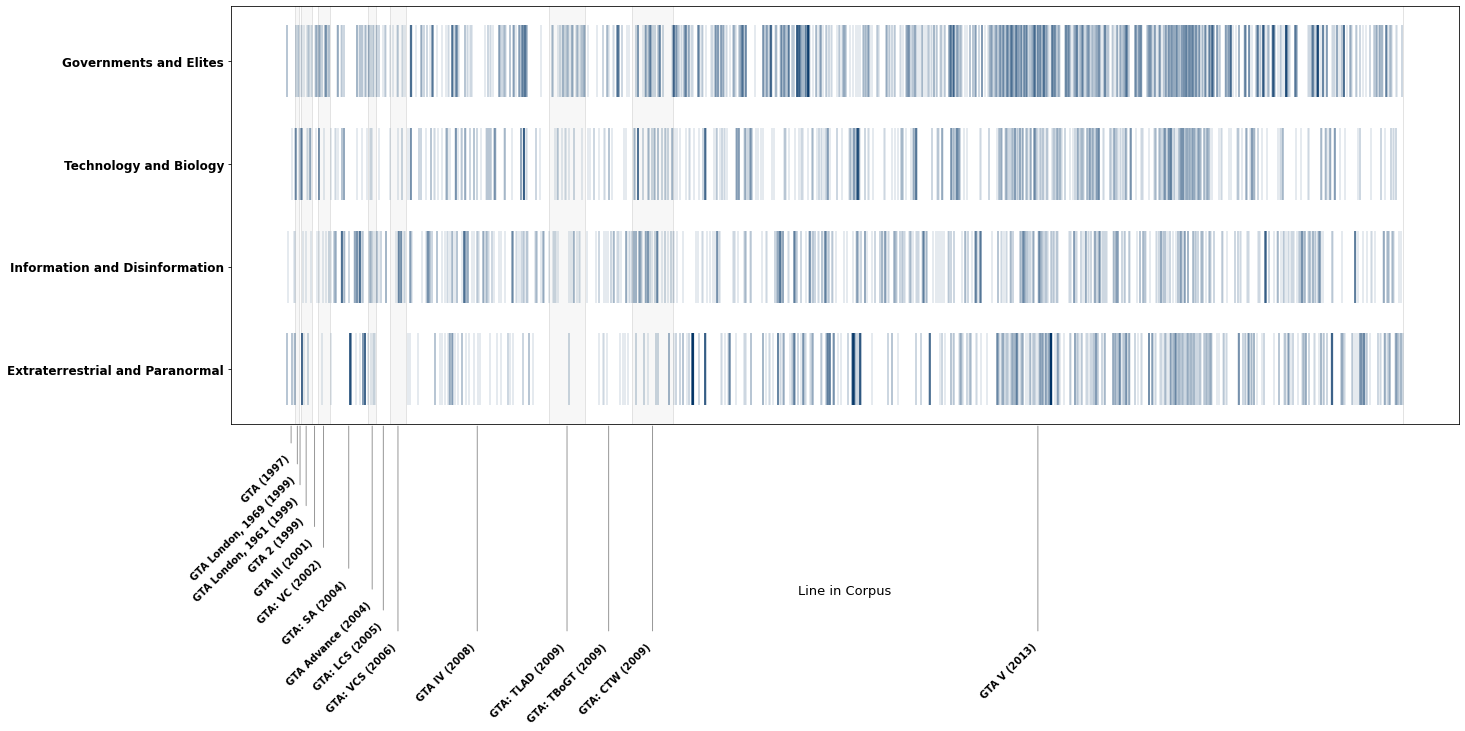

In [9]:
def run_barcode_dimensions(df, categories):
    """
    Creates a barcode of conspiracy categories for thematic dimensions.
    """
    
    # Order
    df_filtered = df[df['Game'].isin(ordered_games)].copy()
    df_filtered['Sort_Order'] = df_filtered['Game'].apply(lambda x: ordered_games.index(x))
    df_sorted = df_filtered.sort_values('Sort_Order').reset_index(drop = True)
    
    all_words = []
    game_boundaries = []
    current_game = None
    
    for i, row in df_sorted.iterrows():
        game = row['Game']
        if game != current_game:
            game_boundaries.append({'start': len(all_words), 'name': game})
            current_game = game
        
        tokens = re.findall(r'\b[a-zA-Z-]{2,}\b', str(row['Text']).lower())
        all_words.extend(tokens)
    
    total_len = len(all_words)
    
    # Set up graph
    category_names = list(categories.keys())
    fig, ax = plt.subplots(figsize = (22, 10))
    colors = ['#ffffff', '#f7f7f7']
    
    # Draw background and labels
    for i, boundary in enumerate(game_boundaries):
        start = boundary['start']
        end = game_boundaries[i + 1]['start'] if i + 1 < len(game_boundaries) else total_len
        short_name = short_names_map.get(boundary['name'], boundary['name'])
        
        ax.axvspan(start, end, facecolor = colors[i % 2], alpha = 1.0, zorder = 0)
        ax.axvline(x = end, color = '#dddddd', lw = 0.8, zorder = 1)
        
        depth_steps = [-0.05, -0.1, -0.15, -0.2, -0.25, -0.3, -0.35, -0.4, -0.45, -0.5]
        
        if i < 9:
            drop_depth = depth_steps[i]
        else:
            drop_depth = depth_steps[-1]
        
        mid = start + (end - start) / 2
        
        ax.annotate('', xy = (mid, 0), xycoords = ('data', 'axes fraction'),
                    xytext = (mid, drop_depth), textcoords = ('data', 'axes fraction'),
                    arrowprops = dict(arrowstyle = '-', color = '#999999', lw = 1))
        
        ax.text(mid, drop_depth - 0.02, short_name, transform = ax.get_xaxis_transform(),
                rotation = 45, ha = 'right', va = 'top', fontsize = 10, fontweight = 'bold')

    # Draw bars
    for idx, (cat_name, patterns) in enumerate(reversed(list(categories.items()))):
        # Combine all patterns of a category into one search
        combined_indices = []
        for pattern_str in patterns:
            regex = wildcard_to_regex(pattern_str)
            indices = [j for j, word in enumerate(all_words) if regex.match(word)]
            combined_indices.extend(indices)
        
        # Plot all hits for a category as vertical lines
        ax.vlines(combined_indices, idx - 0.35, idx + 0.35,
                  colors = '#003366', alpha = 0.5, linewidth = 0.4, zorder = 2)
    
    # Set style
    ax.set_yticks(range(len(category_names)))
    ax.set_yticklabels(reversed(category_names), fontsize = 12, fontweight = 'bold')
    ax.set_xticks([])
    
    ax.set_xlabel('Line in Corpus', fontsize = 13, labelpad = 160)
    
    plt.subplots_adjust(bottom = 0.3)
    plt.savefig('conspiracy_gta_barcode_dimensions.png', dpi = 300, bbox_inches = 'tight')
    
    print("Graph saved as 'conspiracy_gta_barcode_dimensions.png'.")

# Execute
if 'df_master' in locals():
    run_barcode_dimensions(df_master, conspiracy_categories)

# Generate Barcode for Selected Keywords

Graph saved as 'conspiracy_gta_barcode_keywords.png'.


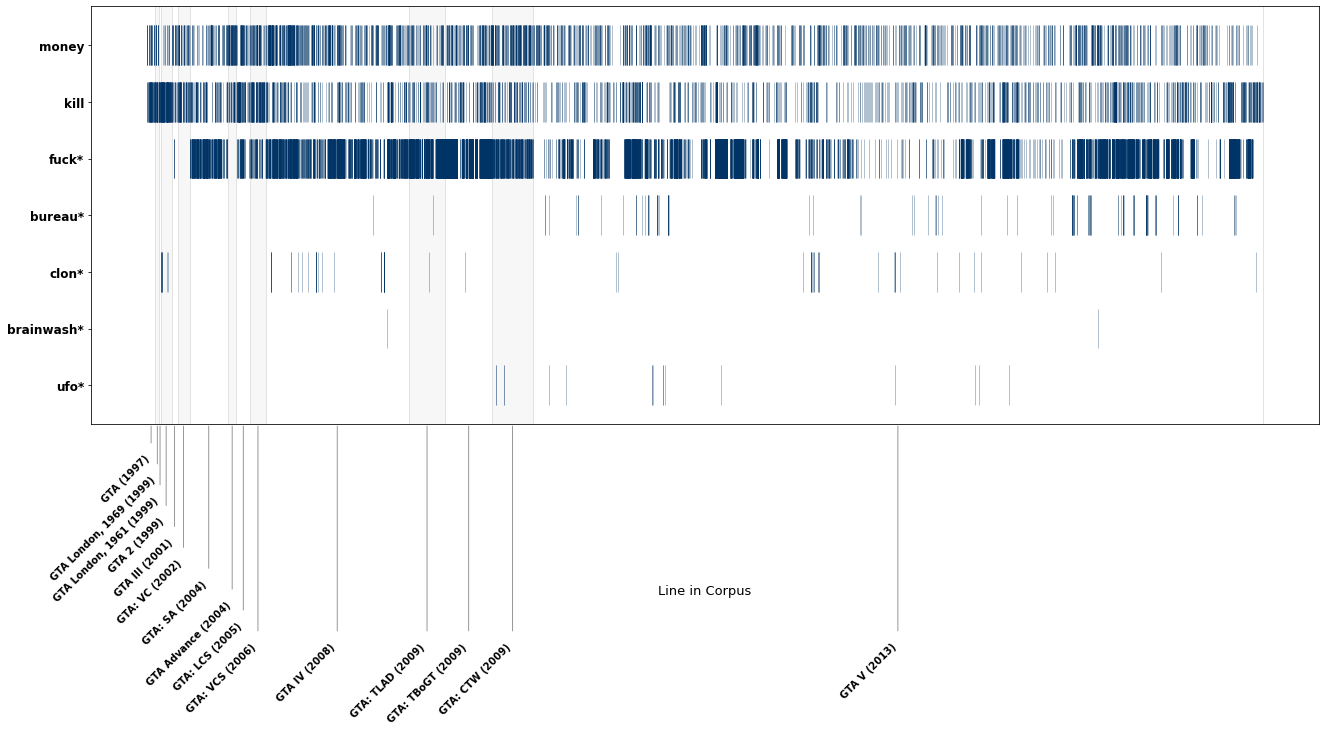

In [10]:
def run_barcode_words(df, target_words):
    """
    Creates a barcode of conspiracy categories by keywords.
    """

    # Order
    df_filtered = df[df['Game'].isin(ordered_games)].copy()
    df_filtered['Sort_Order'] = df_filtered['Game'].apply(lambda x: ordered_games.index(x))
    df_sorted = df_filtered.sort_values('Sort_Order').reset_index(drop = True)
    
    all_words = []
    game_boundaries = []
    current_game = None
    
    for i, row in df_sorted.iterrows():
        game = row['Game']
        if game != current_game:
            game_boundaries.append({'start': len(all_words), 'name': game})
            current_game = game
        
        tokens = re.findall(r'\b[a-zA-Z-]{2,}\b', str(row['Text']).lower())
        all_words.extend(tokens)
    
    total_len = len(all_words)
    
    # Set up graph
    fig, ax = plt.subplots(figsize = (22, 10))
    colors = ['#ffffff', '#f7f7f7']
    
    # Draw background and labels
    for i, boundary in enumerate(game_boundaries):
        start = boundary['start']
        end = game_boundaries[i + 1]['start'] if i + 1 < len(game_boundaries) else total_len
        short_name = short_names_map.get(boundary['name'], boundary['name'])
        
        ax.axvspan(start, end, facecolor = colors[i % 2], alpha = 1.0, zorder = 0)
        ax.axvline(x = end, color = '#dddddd', lw = 0.8, zorder = 1)
        
        depth_steps = [-0.05, -0.1, -0.15, -0.2, -0.25, -0.3, -0.35, -0.4, -0.45, -0.5]
        
        if i < 9:
            drop_depth = depth_steps[i]
        else:
            drop_depth = depth_steps[-1]
        
        mid = start + (end - start) / 2
        
        ax.annotate('', xy = (mid, 0), xycoords = ('data', 'axes fraction'),
                    xytext = (mid, drop_depth), textcoords = ('data', 'axes fraction'),
                    arrowprops = dict(arrowstyle = '-', color = '#999999', lw = 1))
        
        ax.text(mid, drop_depth - 0.02, short_name, transform = ax.get_xaxis_transform(),
                rotation = 45, ha = 'right', va = 'top', fontsize = 10, fontweight = 'bold')

    # Draw bars
    for idx, word in enumerate(reversed(target_words)):
        pattern = wildcard_to_regex(word)
        indices = [j for j, w in enumerate(all_words) if pattern.match(w)]
        
        # Plot all hits for a keyword as vertical lines
        ax.vlines(indices, idx - 0.35, idx + 0.35,
                  colors = '#003366', alpha = 0.6, linewidth = 0.5, zorder = 2)
    
    # Set style
    ax.set_yticks(range(len(target_words)))
    ax.set_yticklabels(reversed(target_words), fontsize = 12, fontweight = 'bold')
    ax.set_xticks([])
    
    ax.set_xlabel('Line in Corpus', fontsize = 13, labelpad = 160)
    
    plt.subplots_adjust(bottom = 0.3)
    plt.savefig('conspiracy_gta_barcode_keywords.png', dpi = 300, bbox_inches = 'tight')
    
    print("Graph saved as 'conspiracy_gta_barcode_keywords.png'.")

# Set keywords
barcode_keywords = ["money", "kill", "fuck*", "bureau*", "clon*", "brainwash*", "ufo*"]

# Execute
if 'df_master' in locals():
    run_barcode_words(df_master, barcode_keywords)